## Overall Project Architecture

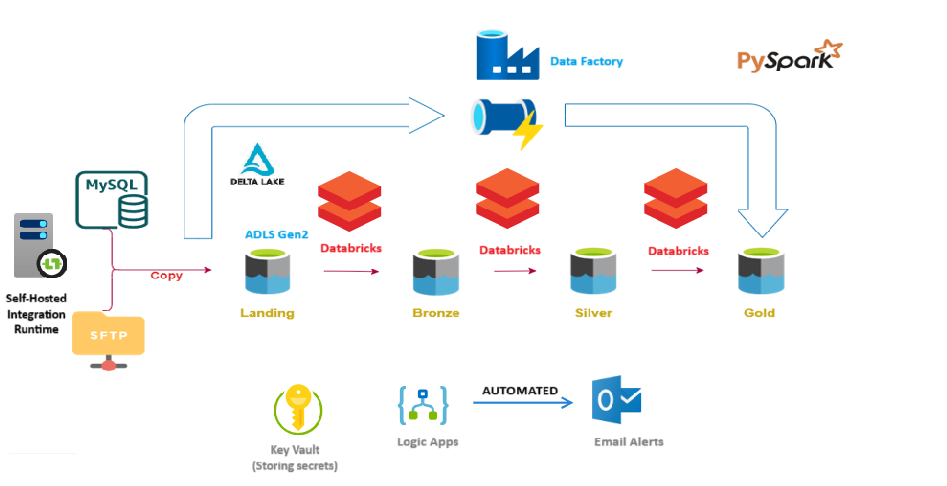

In [0]:
from IPython.display import Image, display
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/Project%20Architecture.png"))

### Order of Execution Of Pipelines(PL):

####**PL-1A -> PL-2A**  
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **===> PL-3 ===> PL-4**  
####**PL-1B -> PL-2B**

#### 1A - MySQL to Landing Container (Extract the Data)

We now extract data from MySQL OnPrem datasource and store it into the landing container in ADLS in parquet format.

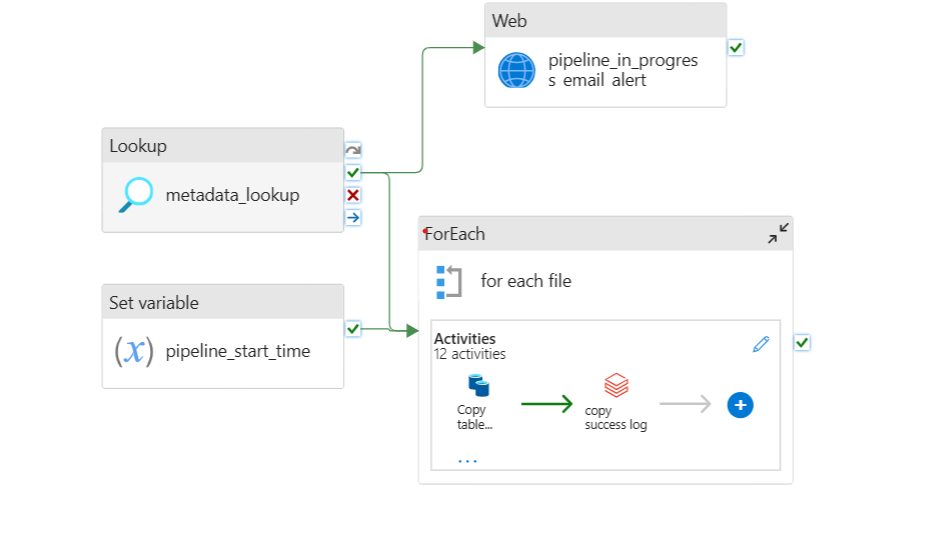

In [0]:
from IPython.display import Image, display
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/sql%20To%20Landing%20Container%201.png"))


- **Lookup Activity** - We use this activity to get relevant parameter details from delta tables so that it can be passed into the pipeline further. `LU activity Expression:`
  - `@concat('SELECT control.source_ref_id,control.job_id, control.server_name, control.port, control.database_name, control.user_name, control.secret_name, control.storage_account, control.adls_url, control.container_name, control.logic_app_url, control.email_id,param.source_file_or_table_name, param.adls_file_path, param.bronze_schema, param.bronze_tbl, param.silver_schema, param.silver_tbl, param.gold_schema, param.gold_tbl FROM ',pipeline().parameters.metadata_database,'.tbl_source_control control JOIN ',pipeline().parameters.metadata_database,'.tbl_parameters param ON control.job_id = param.job_id WHERE param.job_id = ', pipeline().parameters.job_id)`
- **Set variable** -  We use this activity to capture the start time of the pipeline dynamically whenever the pipeline runs.The output of this set variable will be used while triggering automated emails to send the the current pipeline statuses. `pipeline_start_time Expression:`
  - `@formatDateTime(convertFromUtc(utcNow(),'India Standard Time'),'yyyy-MM-dd HH:mm:ss')`
- **Web activity** - It triggers automated email stating the pipeline status `In Progress` using the **Azure Logic App**.



##### Pipeline In progress mail Template


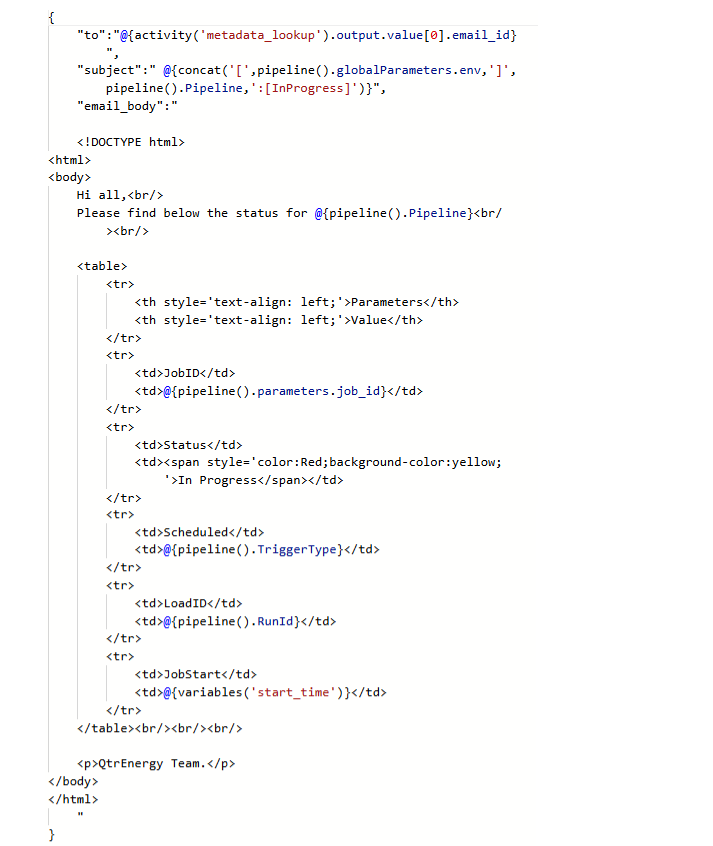

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/Email%20In%20Progress%20Template.png"))

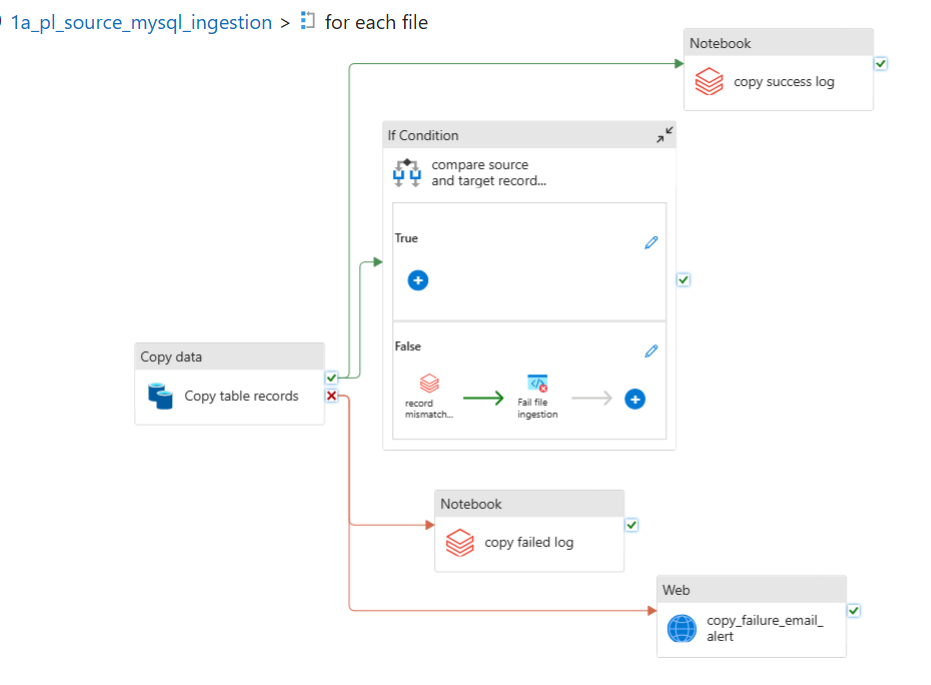

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/sql%20To%20Landing%20Container%202.png"))

- **ForEach Activity** - We use this activity to loop through each file present in the MySQL source location and perform the following:
  - Perform **COPY activity** and log the status of the copy activity into the success or failure log as per the activity result.
  - If the **COPY activity** is fails we use **Web activity** to trigger automated email stating the pipeline status `Source File Copy Failed` using the **Azure Logic App**.
  - If the **COPY activity** is successful we go to **IF activity**.
  - **IF activity** compares the records between the source tables and the records inserted into the landing container. `IF Expression:`
    - `@equals(activity('Copy table records').output.rowsRead,activity('Copy table records').output.rowsCopied)`

       - If there's a mismatch between the records fetched and inserted then :
         - We Log the mismatch records status into the delta log tables through databricks dynamically.
         - We use **Fail activity** to fail the pipline execution and end it.<br/><br/>
       - If the records fetched and the records inserted are equal then we carry on with further execution.

#### 1B - SFTP to Landing Container (Extract the Data)

We now extract data from SFTP OnPrem datasource and store it into the landing container in ADLS in csv format.

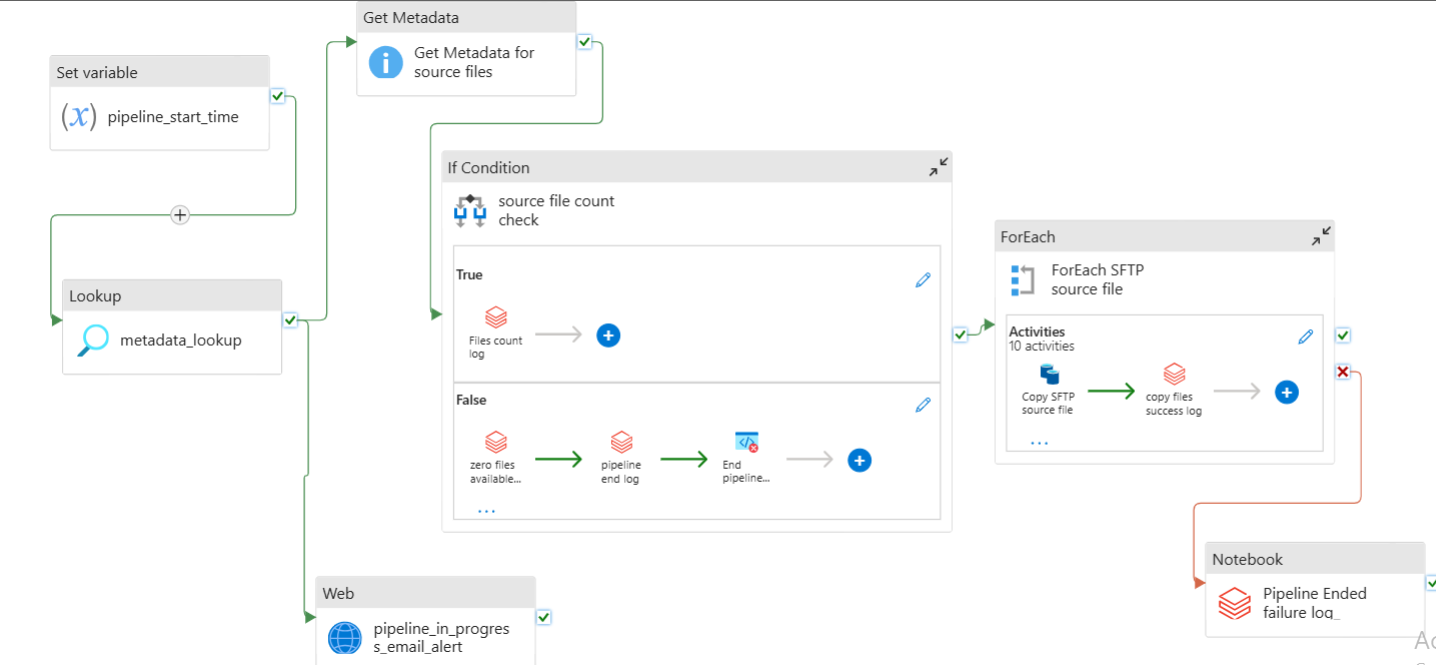

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/SFTP%20To%20Landing%20Container%201.png"))

- **Set variable** -  We use this activity to capture the start time of the pipeline dynamically whenever the pipeline runs.
- **Web activity** - We then use this activity to trigger automated email stating the pipeline status `In Progress` using the **Azure Logic App**.
- **Lookup Activity** - We use this activity to get relevant parameter details from delta tables so that it can be passed into the pipeline further as used in the above SQL case.
- **Get Metadata Activity** -  We leverage the `Child items` property of this activity to get the details regarding the child Items i.e. about the source files in SFTP location.
- **IF activity** - We use this to check if there are any source files in SFTP location by getting the length of `Child Items` from the previous activity.`Expression:`
  -`@greater(length(activity('Get Metadata for source files').output.childItems),0)`<br/>
   - If the **IF activity** condition results to `false` i.e. No source files available, We log the status saying "ZERO files available in source" and then Log "Pipeline Ended",then we use **Fail activity** to stop the pipeline execution. <br/>
  - While **IF activity** condition is `True` i.e. if the length of `child Items` is greater than 0, we log that there are files present in the location, then we move ahead with **ForEach activity.**
- In the **ForEach activity** we perform the **Copy activity** to copy each file present from source to landing container and then log the **Copy activity** status as per the Output.
- If the **ForEach activity** fails we log the `pipeline ended log`.


#### 2A - SQL Landing to Bronze

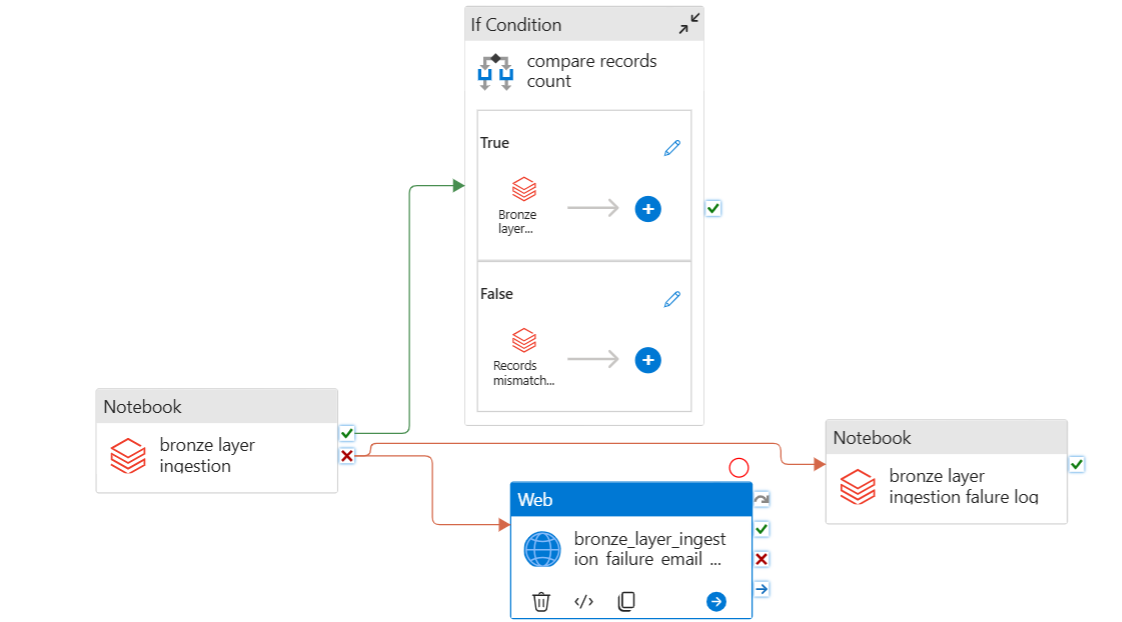

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/SQL%20Landing%20To%20Bronze.png"))

`Bronze layer ingestion` databricks scripts are run dynamically from ADF where we check for the first rows and if it matches the table header row we then remove it. Then we count the number of records after the above process. We then ingest the data into the bronze layer tables and count the records inserted into bronze layer tables and return the count of records to ADF from databricks for further use.<br/>

If the `Bronze layer Ingestion` fails we trigger email stating the same and also log the failure.<br/>

Then, **IF activity** checks if the records inserted and the records available after data quality check are equal, if the the condition satisfies we move ahead with further execution.
If the **IF activity** condition fails, we log the records mismatch between landing container and bronze table.`Expression:`<br/>
   `@equals(activity('bronze layer ingestion').output.runOutput[0],activity('bronze layer ingestion').output.runOutput[1] )`
<br/>
[Link to SQL Landing to Bronze Ingestion Notebook](../Scripts/MySQL%20Bronze%20Ingestion.ipynb)

Once the data is moved to `Bronze Layer` We then archive the source files in to the `archive folder` present in the `landing container`.<br/>
[Link to Archive files Script](../Scripts/archive%20files%20scripts.ipynb)

#### - 2B SFTP Landing To Bronze

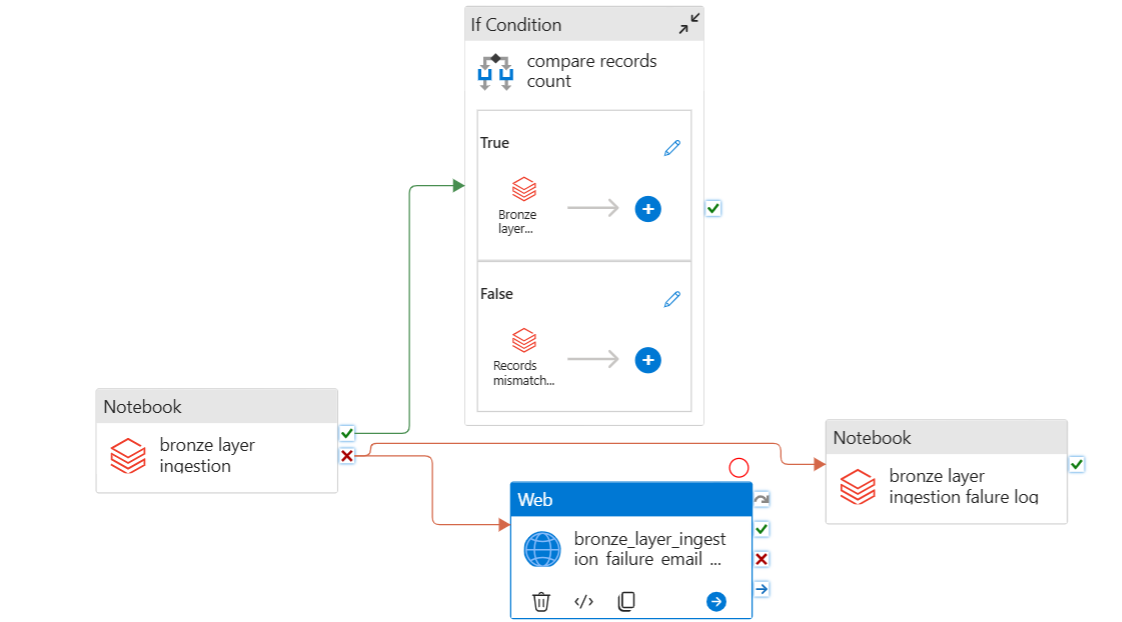

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/SQL%20Landing%20To%20Bronze.png"))

We repeat the same exact process for copying files from the landing folder to bronze tables as mentioned above in `1B SQL Landing To Bronze`.<br/>
[Link to SFTP Landing To Bronze Ingestion Notebook](../Scripts/SFTP%20Bronze%20Ingestion.ipynb)<br/>
Once the data is moved to `Bronze Layer` We then archive the source files in to the `archive folder` present in the `landing container`.<br/>
[Link to Archive files Script](../Scripts/archive%20files%20scripts.ipynb)

#### Bronze to Silver Ingestion

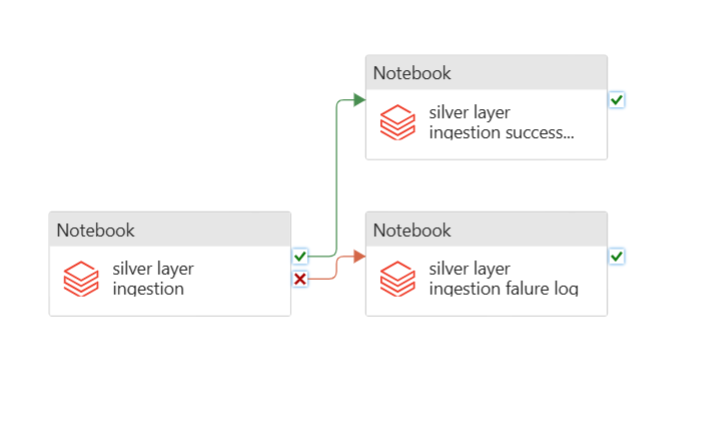

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/Bronze%20to%20Silver%20Ingestion.png"))

We run the bronze to silver ingestion script in which we first count the number of records present in bronze table and then we transform the data by removing duplicates using `dropDuplicates()` function. We then enforce the schema by getting the column data types using: <br/>
`describe table {silver_schema}.{silver_table}` using `spark.sql()` function and then saving it into dataframe.<br/>
`for row in df_schema.collect():`<br/>
    `col_name = row['col_name']`<br/>
    `data_type = row['data_type']`<br/>
    `df = df.withColumn(col_name, col(col_name).cast(data_type))`<br/>

We then insert the transformed `bronze tables` into `silver tables` and return the duplicate records count as well as the silver table record counts to ADF.<br/>
[Link to Bronze to Silver Ingestion Notebook](../Scripts/bronze%20to%20silver%20ingestion.ipynb)

#### 4 - Silver To Gold Ingestion

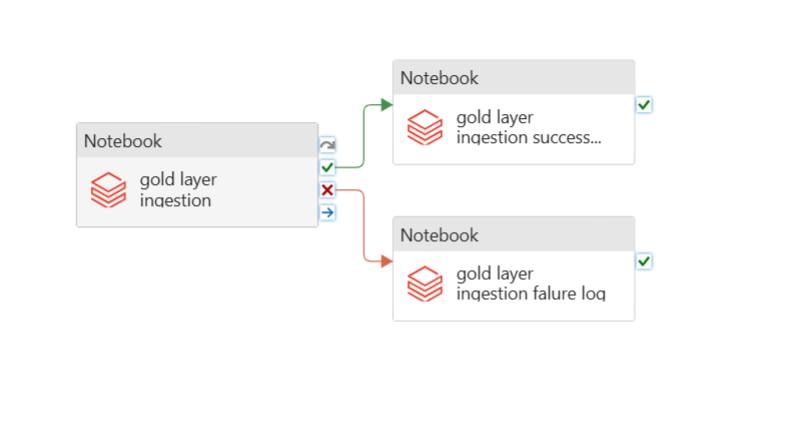

In [0]:
display(Image("https://raw.githubusercontent.com/SALAHUDDINKHAN99/Azure-data-engineering-batch-load-project/main/Images/Silver%20To%20Gold%20Ingestion.png"))

Once the data is in `silver layer`, We then run the `Gold layer Ingestion Scripts` in which we De-Normalize the SFTP `silver tables` into one sinlgle `Gold layer table` for SFTP as the amount of data is not that huge and to avoid unnecessary joins while querying the data for removing insights which may lead to performance optimisation.<br/>
In case of MySQL `silver tables` we directly populate them into `Gold layer tables` as it is already in the required format. Then we log the status as per the Output of Silver to Gold Ingestion script.<br/>
[Link to Silver to Gold Ingestion Notebook](../Scripts/silver%20to%20gold%20ingestion.ipynb)

> Once the data is ingested into gold layer we finally Log the SUCCESS or FAILURE Log and trigger the the email regarding the pipeline status!<br/>
With this we have prepared the data into business ready format ,ready to be queried for removing further Insights from the Gold Layer Data.